# **Sentiment Analysis - AraBERT(Using ArSAS Dataset) -**

**1. Dependencies installation**

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat May 14 12:36:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     |████████████████████████████████| 3.1 MB 8.4 MB/s 
     |████████████████████████████████| 880 kB 54.6 MB/s 
     |████████████████████████████████| 596 kB 63.3 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 46.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=21a2d3450a70afdc00d99768f1701ecd74929009031f605c3134e56bcfb2c79b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 126 kB 9.0 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 564 (delta 25), reused 22 (delta 22),

In [4]:
!git clone https://github.com/mohamedadaly/LABR
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!wget http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
!unzip ArSAS.zip
!unzip '/content/HARD-Arabic-Dataset/data/balanced-reviews.zip'

Cloning into 'LABR'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.
Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (100/100), 116.36 MiB | 30.71 MiB/s, done.
Resolving deltas: 100% (35/35), done.
--2022-05-14 12:39:18--  http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
Resolving homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)... 129.215.32.113
Connecting to homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)|129.215.32.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip [following]
--2022-05-14 12:39:18--  https://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
Connecting to homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)|129.215.32.113|:443... connected.
HTTP request s

**2. Datasets preparation**

In [5]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [6]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [7]:
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [8]:
df_HARD = pd.read_csv("/content/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df_HARD = df_HARD[["review","rating"]]  # we are interested in rating and review only
df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_HARD[LABEL_COLUMN].value_counts())
# code rating as +ve if > 3, -ve if less, no 3s in dataset

hard_map = {
    5: 'POS',
    4: 'POS',
    2: 'NEG',
    1: 'NEG'
}

df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
label_list_HARD = ['NEG', 'POS']

data_Hard = CustomDataset("HARD", train_HARD, test_HARD, label_list_HARD)
all_datasets.append(data_Hard)

2    38467
4    26450
5    26399
1    14382
Name: label, dtype: int64


In [9]:
#@title
%%writefile labr.py
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 10 16:27:03 2013

@author: Mohamed Aly <mohamed@mohamedaly.info>
"""

import codecs
import numpy as np
import pandas as pd
import re

class LABR:
    def __init__(self):
        self.REVIEWS_PATH = "LABR/data/"
        self.RAW_REVIEWS_FILE = "raw_reviews.tsv"
        self.DELETED_REVIEWS_FILE = "deleted_reviews.tsv"
        self.CLEAN_REVIEWS_FILE = "reviews.tsv"

    # Copied from the PyArabic package.
    def arabicrange(self):
        """return a list of arabic characteres .
        Return a list of characteres between \u060c to \u0652
        @return: list of arabic characteres.
        @rtype: unicode;
        """
        mylist=[];
        for i in range(0x0600, 0x00653):
            try :
                mylist.append(unichr(i));
            except ValueError:
                pass;
        return mylist;

    # cleans a single review
    def clean_raw_review(self, body):
         # patterns to remove first
        pat = [\
            (u'http[s]?://[a-zA-Z0-9_\-./~\?=%&]+', u''),               # remove links
            (u'www[a-zA-Z0-9_\-?=%&/.~]+', u''),
#            u'\n+': u' ',                     # remove newlines
            (u'<br />', u' '),                  # remove html line breaks
            (u'</?[^>]+>', u' '),              # remove html markup
#            u'http': u'',
            (u'[a-zA-Z]+\.org', u''),
            (u'[a-zA-Z]+\.com', u''),
            (u'://', u''),
            (u'&[^;]+;', u' '),
            (u':D', u':)'),
#            (u'[0-9/]+', u''),
#            u'[a-zA-Z.]+': u'',
#            u'[^0-9' + u''.join(self.arabicrange()) + \
#                u"!.,;:$%&*%'#(){}~`\[\]/\\\\\"" + \
#                u'\s^><\-_\u201D\u00AB=\u2026]+': u'',          # remove latin characters
            (u'\s+', u' '),                     # remove spaces
            (u'\.+', u'.'),                     # multiple dots
            (u'[\u201C\u201D]', u'"'),          #“
            (u'[\u2665\u2764]', u''),           # heart symbol
            (u'[\u00BB\u00AB]', u'"'),
            (u'\u2013', u'-'),                # dash
        ]

        # patterns that disqualify a review
        remove_if_there = [\
            (u'[^0-9' + u''.join(self.arabicrange()) + \
                u"!.,;:$%&*%'#(){}~`\[\]/\\\\\"" + \
                u'\s\^><\-_\u201D\u00AB=\u2026+|' + \
                u'\u0660-\u066D\u201C\u201D' + \
                u'\ufefb\ufef7\ufef5\ufef9]+', u''),                   # non arabic characters
        ]

        # patterns that disqualify if empty after removing
        remove_if_empty_after = [\
            (u'[0-9a-zA-Z\-_]', u' '),             #alpha-numeric
            (u'[0-9' + u".,!;:$%&*%'#(){}~`\[\]/\\\\\"" + \
                u'\s\^><`\-=_+]+', u''),                  # remove just punctuation
            (u'\s+', u' '),                     # remove spaces
        ]

        # remove again
        # patterns to remove
        pat2 = [\
#            u'[^0-9' + u''.join(self.arabicrange()) + \
#                u"!.,;:$%&*%'#(){}~`\[\]/\\\\\"" + \
#                u'\s^><\-_\u201D\u00AB=\u2026]+': u'',          # remove latin characters
        ]

        skip = False

        # if empty body, skip
        if body == u'': skip = True

        # do some subsitutions
        for k,v in pat:
            body = re.sub(k, v, body)

        # remove if exist
        for k,v in remove_if_there:
            if re.search(k, body):
                skip = True

        # remove if empty after replacing
        for k,v in remove_if_empty_after:
            temp = re.sub(k, v, body)
            if temp == u" " or temp == u"":
                skip = True

        # do some more subsitutions
        if not skip:
            for k,v in pat2:
                body = re.sub(k, v, body)

        # if empty string, skip
        if body == u'' or body == u' ':
            skip = True

        if not skip:
            return body
        else:
            return u""

    # Read raw reviews from file and clean and write into clean_reviews
    def clean_raw_reviews(self):
        # input file
        in_file = codecs.open(self.REVIEWS_PATH + self.RAW_REVIEWS_FILE,
                              'r', encoding="utf-8")
        reviews = in_file.readlines()

        # Output file: rating<tab>content
        out_file = open(self.REVIEWS_PATH + self.CLEAN_REVIEWS_FILE,
                        'w', buffering = 100)
        deleted_file = open(self.REVIEWS_PATH + self.DELETED_REVIEWS_FILE,
                            'w', buffering = 100)

        counter = 1
        for i in xrange(0, len(reviews)):
            review = reviews[i]
            skip = False

#           # If line starts with #, then skip
#            if review[0] == u"#": continue

            # split by <tab>
            parts = review.split(u"\t")

            # rating is first part and body is last part
            rating = parts[0]
            review_id = parts[1]
            user_id = parts[2]
            book_id = parts[3]
            body = parts[4].strip()

            # clean body
            body = self.clean_raw_review(body)
            if body == u"": skip = True

            if i % 5000 == 0:
                print("review %d:" % (i))

            # write output
            line = u"%s\t%s\t%s\t%s\t%s\n" % (rating, review_id, user_id,
                                              book_id, body)
            if not skip:
                out_file.write(line.encode('utf-8'))
                counter += 1
            else:
                deleted_file.write(line.encode('utf-8'))

    # Read the reviews file. Returns a tuple containing these lists:
    #   rating: the rating 1 -> 5
    #   review_id: the id of the review
    #   user_id: the id of the user
    #   book_id: the id of the book
    #   body: the text of the review
    def read_review_file(self, file_name):
        reviews = codecs.open(file_name, 'r', 'utf-8').readlines()

        # remove comment lines and newlines
        reviews = [r.strip() for r in reviews if r[0] != u'#']

        # parse
        rating = list()
        review_id = list()
        user_id = list()
        book_id = list()
        body = list()
        for review in reviews:
            # split by <tab>
            parts = review.split(u"\t")

            # rating is first part and body is last part
            rating.append(int(parts[0]))
            review_id.append(parts[1])
            user_id.append(parts[2])
            book_id.append(parts[3])
            if len(parts) > 4:
                body.append(parts[4])
            else:
                body.append(u"")

        return (rating, review_id, user_id, book_id, body)

    # Writes reviews to a file
    def write_review_file(self, file_name, rating, review_id, user_id,
                          book_id, body):

        lines = list()
        # loop
        for i in xrange(len(rating)):
            line = u"%s\t%s\t%s\t%s\t%s\n" % (rating[i], review_id[i],
                                              user_id[i], book_id[i],
                                              body[i])
            lines.append(line)

        open(file_name, 'w').write(u''.join(lines).encode('utf-8'))

    def read_clean_reviews(self):
        return self.read_review_file(self.REVIEWS_PATH +
                                     self.CLEAN_REVIEWS_FILE)

    def read_raw_reviews(self):
        return self.read_review_file(self.REVIEWS_PATH + self.RAW_REVIEWS_FILE)

    # Splits the dataset into a training/test sets in the setting of using 5
    # classes (predicting the rating value from 1 to 5)
    def split_train_test_5class(self, rating, percent_test,
                                balanced = "unbalanced"):
        np.random.seed(1234)

        num_reviews = len(rating)
        review_ids = np.arange(0, num_reviews)

        if balanced == "unbalanced":
            ntest = np.floor(num_reviews * percent_test)
            np.random.shuffle(review_ids)

            test_ids = review_ids[:ntest]
            train_ids = review_ids[ntest:]

        elif balanced == "balanced":
            (sizes, bins) = np.histogram(rating, [1, 2, 3, 4, 5, 6])
            min_size = np.min(sizes)
            print(min_size)

            # sample review ids equally among classes
            test_ids = np.zeros((0,), dtype="int32")
            train_ids = np.zeros((0,), dtype="int32")
            rating = np.array(rating)
            ntest = np.floor(min_size * percent_test)
            for c in range(1, 6):
                cids = review_ids[np.nonzero(rating == c)]
                np.random.shuffle(cids)

                test_ids = np.r_[test_ids, cids[:ntest]]
                train_ids = np.r_[train_ids, cids[ntest:min_size]]

        train_file = self.REVIEWS_PATH + "5class-" + balanced+ "-train.txt"
        test_file = self.REVIEWS_PATH + "5class-" + balanced+ "-test.txt"

        open(train_file, 'w').write('\n'.join(map(str, train_ids)))
        open(test_file, 'w').write('\n'.join(map(str, test_ids)))

        return (train_ids, test_ids)

    # Splits the dataset into a training/test sets in the setting of using 2
    # classes (predicting the polarity of the review where ratings 1 & 2
    # are considered negative, ratings 4 & 5 are positive, and rating 3 is
    # ignored)
    def split_train_test_2class(self, rating, percent_test,
                                balanced = "unbalanced"):
        np.random.seed(1234)

        rating = np.array(rating, dtype='int32')
        # length
        num_reviews = len(rating)
        review_ids = np.arange(0, num_reviews)

        # convert to binary, with ratings [1, 2] --> neg and [4, 5] --> pos
        rating[rating == 2] = 1
        rating[rating == 4] = 5

        ids = (rating == 1) + (rating == 5)
        review_ids = review_ids[ids]
        rating = rating[ids]
        rating[rating == 1] = 0
        rating[rating == 5] = 1

        # get length after filtering
        num_reviews = rating.shape[0]

        if balanced == "unbalanced":
            ntest = np.floor(num_reviews * percent_test)
            np.random.shuffle(review_ids)

            test_ids = review_ids[:ntest]
            train_ids = review_ids[ntest:]

        elif balanced == "balanced":
            (sizes, bins) = np.histogram(rating, [0, 1, 2])
            min_size = np.min(sizes)
            print(min_size)

            # sample review ids equally among classes
            test_ids = np.zeros((0,), dtype="int32")
            train_ids = np.zeros((0,), dtype="int32")
            rating = np.array(rating)
            ntest = np.floor(min_size * percent_test)
            for c in [0, 1]:
                cids = review_ids[np.nonzero(rating == c)]
                np.random.shuffle(cids)

                test_ids = np.r_[test_ids, cids[:ntest]]
                train_ids = np.r_[train_ids, cids[ntest:min_size]]

        train_file = self.REVIEWS_PATH + "2class-" + balanced+ "-train.txt"
        test_file = self.REVIEWS_PATH + "2class-" + balanced+ "-test.txt"

        open(train_file, 'w').write('\n'.join(map(str, train_ids)))
        open(test_file, 'w').write('\n'.join(map(str, test_ids)))

        return (train_ids, test_ids)

    # Reads a training or test file. The file contains the indices of the
    # reviews from the clean reviews file.
    def read_train_test_file(self, file_name):
        ins = open(file_name).readlines()
        ins = [int(i.strip()) for i in ins]

        return ins

    # A helpter function.
    def set_binary_klass(self, ar):
        ar[(ar == 1) + (ar == 2)] = 0
        ar[(ar == 4) + (ar == 5)] = 1

    # Returns (train_x, train_y, test_x, test_y)
    # where x is the review body and y is the rating (1->5 or 0->1)
    def get_train_test(self, klass = "2", balanced = "balanced"):
        (rating, a, b, c, body) = self.read_clean_reviews()
        rating = np.array(rating)
        body = pd.Series(body)

        train_file = (self.REVIEWS_PATH + klass + "class-" +
            balanced+ "-train.txt")
        test_file = (self.REVIEWS_PATH + klass + "class-" +
            balanced+ "-test.txt")

        train_ids = self.read_train_test_file(train_file)
        test_ids = self.read_train_test_file(test_file)

        train_y = rating[train_ids]
        test_y = rating[test_ids]
        train_x = body[train_ids]
        test_x = body[test_ids]

        if klass == "2":
            self.set_binary_klass(train_y)
            self.set_binary_klass(test_y)

        return (train_x, train_y, test_x, test_y)

Writing labr.py


In [10]:
from labr import LABR

labr_helper = LABR()

(d_train, y_train, d_test, y_test) = labr_helper.get_train_test(
    klass="2", balanced="unbalanced"
)

train_LABR_B_U = pd.DataFrame({DATA_COLUMN: d_train, LABEL_COLUMN: y_train})
test_LABR_B_U = pd.DataFrame({DATA_COLUMN: d_test, LABEL_COLUMN: y_test})

train_LABR_B_U[LABEL_COLUMN] = train_LABR_B_U[LABEL_COLUMN].apply(lambda x: 'NEG' if (x == 0) else 'POS')
test_LABR_B_U[LABEL_COLUMN] = test_LABR_B_U[LABEL_COLUMN].apply(lambda x: 'NEG' if (x == 0) else 'POS')

print(train_LABR_B_U[LABEL_COLUMN].value_counts() + test_LABR_B_U[LABEL_COLUMN].value_counts())
label_list_LABR_B_U = list(test_LABR_B_U[LABEL_COLUMN].unique())

data_LABR_B_U = CustomDataset(
    "LABR-UN-Binary", train_LABR_B_U, test_LABR_B_U, label_list_LABR_B_U
)
all_datasets.append(data_LABR_B_U)


POS    42832
NEG     8224
Name: label, dtype: int64


In [11]:
df_ArSAS = pd.read_csv("/content/ArSAS..txt", sep="\t",encoding='utf-8')
df_ArSAS = df_ArSAS[["Tweet_text","Sentiment_label"]]  
df_ArSAS.columns = [DATA_COLUMN, LABEL_COLUMN]
print("Total length: ", len(df_ArSAS))
print(df_ArSAS[LABEL_COLUMN].value_counts())

label_list_ArSAS = list(df_ArSAS[LABEL_COLUMN].unique())
print(label_list_ArSAS)

train_ArSAS, test_ArSAS = train_test_split(df_ArSAS, test_size=0.2, random_state=42)
print("Training length: ", len(train_ArSAS))
print("Testing length: ", len(test_ArSAS))
data_ArSAS = CustomDataset("ArSAS", train_ArSAS, test_ArSAS, label_list_ArSAS)
all_datasets.append(data_ArSAS)

Total length:  19897
Negative    7384
Neutral     6894
Positive    4400
Mixed       1219
Name: label, dtype: int64
['Positive', 'Negative', 'Neutral', 'Mixed']
Training length:  15917
Testing length:  3980


**3. Training procedure**

In [12]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [13]:
for x in all_datasets:
  print(x.name)

HARD
LABR-UN-Binary
ArSAS


In [14]:
dataset_name = 'ArSAS'
model_name = 'aubmindlab/bert-base-arabertv02-twitter' 

In [15]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


In [16]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [17]:
list(selected_dataset.train[DATA_COLUMN][0:10])

['# بطولات - " ميرور " : محمد صلاح صفقة الموسم يتفوق على لاعبي البريمرليج [رابط]',
 'أعجبني فيديو على [رابط] هدفين محمد صلاح واسيست رائع ضد وستهام',
 'تصريح # قطر _ ساندويتش يعكس حالة الافاقه من حلم العضامية التي كانت تعيشه الحكومة القطرية ايام الربيع العربي المحرق وانها بدأت تعرف حجمها ! بقي الان ان تفهم ان لامجال لكذبة الحياد فافعالها السابقة تدينها ! وان تعي ان عمقها عربي خليجي سني والمهادنة مع شريفة لن يجعلها بعيدة عن اطماعها',
 'هم اهل للغش والمرضوالدولة تبي تطلعهمولا تنسى أزمة الخليجكل الخليج قاموا مع السعودية الا السودانولا نسيت ؟ يلا رد ياحرمه 😂 😂',
 'الكل يعلم أن جبهه النصره أستخدمت اللأسلحه الكيماويه بخان شيخون والدول التى تتهم سوريا هى من نقل السلاح الكيماوى من ليبيا لتركيا لجبهه النصره # كلاب الربيع العربى يدعمون الارهاب حتى اليوم [رابط]',
 '# سبق | ناصر حسان يشكر الرئيس # السيسي ويؤكد أنه سيكون سفير مصر بالخارج # منتدي _ شباب _ العالم # حفل _ الختام # weneedtotalk [رابط]',
 '# خالد _ عليلاتكن حمدين صباحي',
 '1 - الشعب اليمني قام بثورة ضد علي صالح 2 - علي صالح قاتلهم واهلك 

In [18]:
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


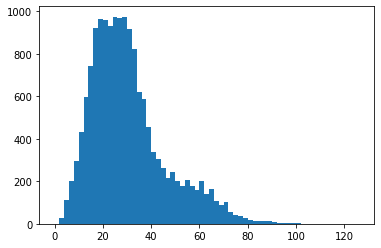

Testing Sentence Lengths: 


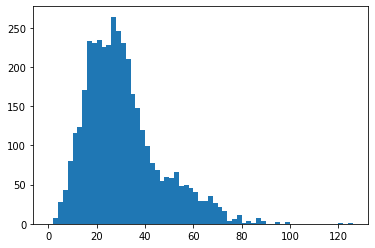

In [19]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

In [20]:
max_len = 128

In [21]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  8
Truncated testing sequences:  8


In [22]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [23]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Mixed': 3}


In [24]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 10, 12279, 19, 9, 51185, 9, 31, 582, 3173, 5987, 2095, 27989, 323, 5518, 9435, 420, 1258, 64, 3879, 66, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [25]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [26]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [27]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

**4. Regular Training**

In [28]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

In [29]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [30]:
trainer.train()

***** Running training *****
  Num examples = 15917
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 994


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.533326,0.630061,0.794724
1,0.614100,0.532766,0.657272,0.796985


***** Running Evaluation *****
  Num examples = 3980
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-497
Configuration saved in ./train/checkpoint-497/config.json
Model weights saved in ./train/checkpoint-497/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3980
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-994
Configuration saved in ./train/checkpoint-994/config.json
Model weights saved in ./train/checkpoint-994/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-994 (score: 0.657271963641283).


TrainOutput(global_step=994, training_loss=0.5354030616806307, metrics={'train_runtime': 770.2601, 'train_samples_per_second': 41.329, 'train_steps_per_second': 1.29, 'total_flos': 2093151809608704.0, 'train_loss': 0.5354030616806307, 'epoch': 2.0})

In [31]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: 'Positive', 1: 'Negative', 2: 'Neutral', 3: 'Mixed'}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [32]:
!cp output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory 'output_dir'


**5. Predict Using The Saved Model**

In [33]:
from transformers import pipeline

In [34]:
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=True)

loading configuration file output_dir/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_

In [35]:
pipe("Some Text")

[[{'label': 'Positive', 'score': 0.088777095079422},
  {'label': 'Negative', 'score': 0.06401639431715012},
  {'label': 'Neutral', 'score': 0.8265421986579895},
  {'label': 'Mixed', 'score': 0.020664332434535027}]]

**6. K-fold & Ensemble all the cross validation models**

In [36]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [37]:
inv_label_map = { v:k for k, v in label_map.items()}

In [38]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

In [39]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")
  
  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)
  
  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)
  
  training_args = TrainingArguments( 
    output_dir= f"./train_{fold_num}",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*" 
  
  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.570255,0.602140,0.789259
1,No log,0.561956,0.607954,0.788945


***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_0/checkpoint-99
Configuration saved in ./train_0/checkpoint-99/config.json
Model weights saved in ./train_0/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_0/checkpoint-198
Configuration saved in ./train_0/checkpoint-198/config.json
Model weights saved in ./train_0/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_0/checkpoint-198 (score: 0.6079539714099805).
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128


Saving model checkpoint to ./train_0/best_model
Configuration saved in ./train_0/best_model/config.json


{'eval_loss': 0.5619563460350037, 'eval_macro_f1': 0.6079539714099805, 'eval_accuracy': 0.7889447236180904, 'eval_runtime': 25.8254, 'eval_samples_per_second': 123.29, 'eval_steps_per_second': 0.968, 'epoch': 1.99}


Model weights saved in ./train_0/best_model/pytorch_model.bin
tokenizer config file saved in ./train_0/best_model/tokenizer_config.json
Special tokens file saved in ./train_0/best_model/special_tokens_map.json


**************************New Best Model Found!**************************
**************************Starting Fold Num:  1  **************************


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.591625,0.592066,0.773241
1,No log,0.567663,0.616031,0.780465


***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_1/checkpoint-99
Configuration saved in ./train_1/checkpoint-99/config.json
Model weights saved in ./train_1/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_1/checkpoint-198
Configuration saved in ./train_1/checkpoint-198/config.json
Model weights saved in ./train_1/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_1/checkpoint-198 (score: 0.6160311742051623).
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128


Saving model checkpoint to ./train_1/best_model
Configuration saved in ./train_1/best_model/config.json


{'eval_loss': 0.567663311958313, 'eval_macro_f1': 0.6160311742051623, 'eval_accuracy': 0.780464824120603, 'eval_runtime': 25.6981, 'eval_samples_per_second': 123.9, 'eval_steps_per_second': 0.973, 'epoch': 1.99}


Model weights saved in ./train_1/best_model/pytorch_model.bin
tokenizer config file saved in ./train_1/best_model/tokenizer_config.json
Special tokens file saved in ./train_1/best_model/special_tokens_map.json


**************************New Best Model Found!**************************
**************************Starting Fold Num:  2  **************************


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.584517,0.611942,0.781024
1,No log,0.562371,0.627006,0.790763


***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_2/checkpoint-99
Configuration saved in ./train_2/checkpoint-99/config.json
Model weights saved in ./train_2/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_2/checkpoint-198
Configuration saved in ./train_2/checkpoint-198/config.json
Model weights saved in ./train_2/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_2/checkpoint-198 (score: 0.6270059820037497).
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128


Saving model checkpoint to ./train_2/best_model
Configuration saved in ./train_2/best_model/config.json


{'eval_loss': 0.5623705983161926, 'eval_macro_f1': 0.6270059820037497, 'eval_accuracy': 0.7907634307257304, 'eval_runtime': 25.6667, 'eval_samples_per_second': 124.013, 'eval_steps_per_second': 0.974, 'epoch': 1.99}


Model weights saved in ./train_2/best_model/pytorch_model.bin
tokenizer config file saved in ./train_2/best_model/tokenizer_config.json
Special tokens file saved in ./train_2/best_model/special_tokens_map.json


**************************New Best Model Found!**************************
**************************Starting Fold Num:  3  **************************


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.579006,0.601965,0.788250
1,No log,0.570773,0.609089,0.791706


***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_3/checkpoint-99
Configuration saved in ./train_3/checkpoint-99/config.json
Model weights saved in ./train_3/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_3/checkpoint-198
Configuration saved in ./train_3/checkpoint-198/config.json
Model weights saved in ./train_3/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_3/checkpoint-198 (score: 0.6090894312159227).
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128


Saving model checkpoint to ./train_3/best_model
Configuration saved in ./train_3/best_model/config.json


{'eval_loss': 0.5707730054855347, 'eval_macro_f1': 0.6090894312159227, 'eval_accuracy': 0.7917059377945335, 'eval_runtime': 25.7547, 'eval_samples_per_second': 123.589, 'eval_steps_per_second': 0.971, 'epoch': 1.99}


Model weights saved in ./train_3/best_model/pytorch_model.bin
tokenizer config file saved in ./train_3/best_model/tokenizer_config.json
Special tokens file saved in ./train_3/best_model/special_tokens_map.json


**************************Starting Fold Num:  4  **************************


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.564222,0.605952,0.789193
1,No log,0.551907,0.616201,0.795476


***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_4/checkpoint-99
Configuration saved in ./train_4/checkpoint-99/config.json
Model weights saved in ./train_4/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_4/checkpoint-198
Configuration saved in ./train_4/checkpoint-198/config.json
Model weights saved in ./train_4/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_4/checkpoint-198 (score: 0.6162014099593958).
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128


Saving model checkpoint to ./train_4/best_model
Configuration saved in ./train_4/best_model/config.json


{'eval_loss': 0.5519065260887146, 'eval_macro_f1': 0.6162014099593958, 'eval_accuracy': 0.7954759660697456, 'eval_runtime': 25.7138, 'eval_samples_per_second': 123.786, 'eval_steps_per_second': 0.972, 'epoch': 1.99}


Model weights saved in ./train_4/best_model/pytorch_model.bin
tokenizer config file saved in ./train_4/best_model/tokenizer_config.json
Special tokens file saved in ./train_4/best_model/special_tokens_map.json


In [40]:
all_results

[{'epoch': 1.99,
  'eval_accuracy': 0.7889447236180904,
  'eval_loss': 0.5619563460350037,
  'eval_macro_f1': 0.6079539714099805,
  'eval_runtime': 25.8254,
  'eval_samples_per_second': 123.29,
  'eval_steps_per_second': 0.968},
 {'epoch': 1.99,
  'eval_accuracy': 0.780464824120603,
  'eval_loss': 0.567663311958313,
  'eval_macro_f1': 0.6160311742051623,
  'eval_runtime': 25.6981,
  'eval_samples_per_second': 123.9,
  'eval_steps_per_second': 0.973},
 {'epoch': 1.99,
  'eval_accuracy': 0.7907634307257304,
  'eval_loss': 0.5623705983161926,
  'eval_macro_f1': 0.6270059820037497,
  'eval_runtime': 25.6667,
  'eval_samples_per_second': 124.013,
  'eval_steps_per_second': 0.974},
 {'epoch': 1.99,
  'eval_accuracy': 0.7917059377945335,
  'eval_loss': 0.5707730054855347,
  'eval_macro_f1': 0.6090894312159227,
  'eval_runtime': 25.7547,
  'eval_samples_per_second': 123.589,
  'eval_steps_per_second': 0.971},
 {'epoch': 1.99,
  'eval_accuracy': 0.7954759660697456,
  'eval_loss': 0.551906526088

In [41]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.6152563937588422

In [42]:
from transformers import pipeline
import more_itertools

In [43]:
inv_label_map = { v:k for k, v in label_map.items()}

In [44]:
pred_df = selected_dataset.test[DATA_COLUMN]

In [45]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("sentiment-analysis", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

loading configuration file train_0/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

Disabling tokenizer parallelism, we're using DataLoader multithreading already
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:910: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
loading configuration file train_1/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "cla

0it [00:00, ?it/s]

loading configuration file train_2/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

loading configuration file train_3/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

loading configuration file train_4/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

In [46]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)  
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [47]:
cross_val_df['preds'] = final_labels 
cross_val_df['sentiment_score'] = final_scores 

In [48]:
cross_val_df['preds'].value_counts()

Negative    1599
Neutral     1425
Positive     943
Mixed         13
Name: preds, dtype: int64

In [49]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

              precision    recall  f1-score   support

       Mixed       0.38      0.02      0.04       226
    Negative       0.80      0.88      0.84      1443
     Neutral       0.84      0.85      0.84      1408
    Positive       0.72      0.76      0.74       903

    accuracy                           0.79      3980
   macro avg       0.69      0.63      0.62      3980
weighted avg       0.77      0.79      0.77      3980

